In [1]:
import numpy as np
import healpy as hp
import astropy.io.fits as pyfits
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('~/latex-cm.mplstyle')

import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
# load in many cos angle version
filename = '/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/expacs_share/parma_cpp_edit/AngOutCsv/SpaceportTucson_Arizona_2025_8_31_alt30000m.csv'
location = 'tucson'
date = '2025_8_31'

!mkdir -p {location}_{date}_maps/gifs
!mkdir -p {location}_{date}_maps/fits
!mkdir -p {location}_{date}_maps/sim

maps_dir = f'/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/{location}_{date}_maps'

In [3]:
df = pd.read_csv(filename)

In [4]:
def make_flux_map(nside, df, particle, energy):
    _df = df.query('particle == "{}" & energy == {}'.format(particle, energy))
    costhetas = _df['costheta'].values
    delta_costheta = 2.0/(len(costhetas) - 1)
    # print(delta_costheta)
    fluxes = _df['flux'].values # /cm2/s/MeV/sr

    npix = hp.nside2npix(nside)
    flux_map = np.zeros(npix)

    for ipix in range(npix):
        ang = hp.pix2ang(nside, ipix, nest=False)
        costheta = np.cos(ang[0])

        flux = 0
        if costheta >= 1.0 - delta_costheta:
            flux = fluxes[-2]
        else:
            index_costheta = int((costheta + 1)/delta_costheta)
            fraction = (costheta + 1)/delta_costheta - index_costheta
            flux = (1.0 - fraction) * fluxes[index_costheta] + fraction * fluxes[index_costheta + 1]

        flux_map[ipix] = flux # /cm2/s/MeV/sr

    # if do_multi_solid_angle:
    #     flux_map *= hp.nside2pixarea(nside) # /cm2/s/MeV/sr -> /cm2/s/MeV

    # if use_unit_keV:
    # flux_map /= 1e3 # /MeV -> /keV

    return flux_map

In [5]:
# particle dictionary defining particle labels and PDG code
particle_dict = {'neutro':['Neutron', '2112'], 'proton':['Proton', '2212'], 'he---4':['Helium-4','1000020040'], 'muplus':['$\\mu^+$','-13'], 'mumins': ['$\\mu^-$','13'], 'electr':['Electron', '11'], 'positr':['Positron', '-11'], 'photon': ['Photon', '22']}

# start by previewing one particle's data
particle = 'he---4'
particle_name = particle_dict[particle][0]
primary_PDG = particle_dict[particle][1]

In [6]:
_df = df.query('particle == "{}"'.format(particle))
energies = np.sort(np.unique(_df['energy']))
print('# of Energies:', len(energies))
_df

# of Energies: 80


,particle,energy,costheta,flux,year,month,day,lat(deg),lon(deg),alti(m),g
22220,he---4,0.011294,-1.00,1.674805e-06,2025,8,31,32.0852,110.943,30000,10
22221,he---4,0.011294,-0.98,1.682939e-06,2025,8,31,32.0852,110.943,30000,10
22222,he---4,0.011294,-0.96,1.690975e-06,2025,8,31,32.0852,110.943,30000,10
22223,he---4,0.011294,-0.94,1.698914e-06,2025,8,31,32.0852,110.943,30000,10
22224,he---4,0.011294,-0.92,1.706755e-06,2025,8,31,32.0852,110.943,30000,10
...,...,...,...,...,...,...,...,...,...,...,...
30295,he---4,897160.000000,0.92,4.382845e-13,2025,8,31,32.0852,110.943,30000,10
30296,he---4,897160.000000,0.94,4.384721e-13,2025,8,31,32.0852,110.943,30000,10
30297,he---4,897160.000000,0.96,4.385083e-13,2025,8,31,32.0852,110.943,30000,10
30298,he---4,897160.000000,0.98,4.383742e-13,2025,8,31,32.0852,110.943,30000,10


In [7]:
nside = 32

In [8]:
all_flux_maps = []
# for each energy bin
for i in range(len(energies)):
    # run make_flux_map for each energy bin
    flux_map = make_flux_map(nside, df, particle, energies[i])
    all_flux_maps.append(flux_map)

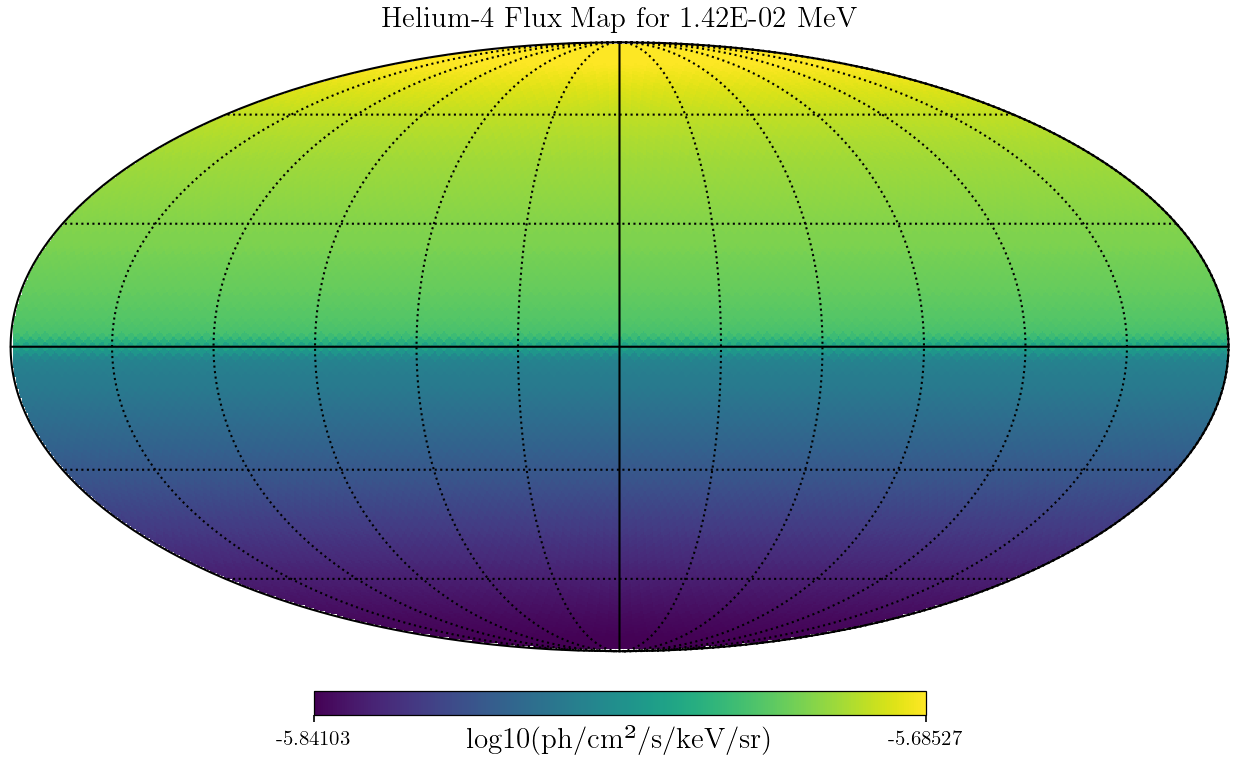

In [9]:
energy_bin = 1
hp.mollview(
    np.log10(all_flux_maps[energy_bin]),
    title=f"{particle_name} Flux Map for {energies[energy_bin]:.2E} MeV",
    unit="log10(ph/cm²/s/keV/sr)"
)
hp.graticule()
plt.show()

In [10]:
from ipywidgets import interact, IntSlider

# all_flux_maps: shape (N_energy, N_pix)
# energies: array-like of length N_energy (MeV)

def show_map(bin_idx):
    hp.mollview(
        np.log10(np.asarray(all_flux_maps[bin_idx])),
        title=f"{particle_name} Flux Map for {energies[bin_idx]:.2E} MeV",
        unit="log10(ph/cm²/s/MeV/sr)"
    )
    hp.graticule()
    plt.show()

interact(
    show_map,
    bin_idx=IntSlider(min=0, max=len(energies)-1, step=1, value=min(10, len(energies)-1), description="Energy bin")
)

interactive(children=(IntSlider(value=10, description='Energy bin', max=79), Output()), _dom_classes=('widget-…

<function __main__.show_map(bin_idx)>

In [11]:
# # loop through all particles and produce animations
# fps = 5
# use_log10 = True

# for particle in particle_dict.keys():
#     _df = df.query('particle == "{}"'.format(particle))

#     particle_name = particle_dict[particle][0]

#     energies = np.sort(np.unique(_df['energy']))
#     N = len(energies)
    
#     all_flux_maps = []
#     for i in range(N):
#         # run make_flux_map for each energy bin
#         flux_map = make_flux_map(nside, df, particle, energies[i])
#         all_flux_maps.append(flux_map)

#     fig = plt.figure(figsize=(8, 5))

#     def draw_frame(i):
#         plt.clf()
#         data = np.asarray(all_flux_maps[i])
#         if use_log10:
#             data = np.log10(np.maximum(data, 1e-30))
#         hp.mollview(
#             data,
#             # min=vmin_log if use_log10 else 10**vmin_log,
#             # max=vmax_log if use_log10 else 10**vmax_log,
#             title=f"{particle_name} Flux Map for {energies[i]:.2E} MeV",
#             unit="log10(1/cm²/s/MeV/sr)" if use_log10 else "1/cm²/s/MeV/sr",
#             fig=fig.number
#         )
#         hp.graticule()

#     step = 2  # keep every 2nd frame
#     ani = animation.FuncAnimation(fig, draw_frame, frames=range(0, N, step), interval=1000 / fps)

#     file = f"{location}_{date}_maps/gifs/{particle}_maps.gif"
#     ani.save(file, writer="pillow", fps=fps*1.5, dpi=200)

#     plt.close(fig)
#     print(f"Saved animation to {file}")


## Run mk_healpix_map.py

In [12]:
# # convert to healpix maps using mk_healpix_map.py
# for particle in particle_dict.keys():
#     output =f'{location}_{date}_maps/fits/{location}_{date}_{particle}.fits'
#     !python /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/expacs_share/fitsfile_20221207/mk_healpix_map.py "{filename}" "{output}" "{particle}"

## Validate HEALPix Maps From mk_healpix_map.py

In [13]:
particle = 'mumins'
particle_name = particle_dict[particle][0]
primary_PDG = particle_dict[particle][1]

fits_file = f'{maps_dir}/fits/{location}_{date}_{particle}.fits'

In [14]:
all_maps = hp.read_map(fits_file, field=None)  # list of maps

header = pyfits.open(fits_file)[1].header

n_map = header["TFIELDS"]
nside = header["NSIDE"]
map_names = []
for i in range(n_map):
    map_names.append(header["TTYPE{}".format(i+1)])

print(header)

def show_map(bin_idx):
    hp.mollview(
        np.log10(all_maps[bin_idx]), 
        title = map_names[bin_idx], 
        unit = header["TUNIT{}".format(bin_idx+1)], 
        rot = (0, 0)
    )
    hp.graticule()
    plt.show()

interact(
    show_map,
    bin_idx=IntSlider(min=0, max=len(all_maps)-1, step=1, value=min(10, len(all_maps)-1), description="Energy bin")
)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =               655360 / length of dimension 1                          NAXIS2  =                   12 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   80 / number of table fields                         TTYPE1  = 'map_E_0.011294_MeV'                                                  TFORM1  = '1024D   '                                                            TUNIT1  = 'ph/cm2/MeV/sr/s'                                                     TTYPE2  = 'map_E_0.014219_MeV'                                                  TFORM2  = '1024D   '                    

interactive(children=(IntSlider(value=10, description='Energy bin', max=79), Output()), _dom_classes=('widget-…

<function __main__.show_map(bin_idx)>

In [15]:
# pyfits.info(fits_file)

In [16]:
# # header = pyfits.open(fits_file)[1].header
# from astropy.table import Table
# t = Table.read(fits_file, hdu=2)

# t.show_in_notebook()
# # with pyfits.open(fits_file) as hdul:
# #     hdu = hdul[1]
# #     print(hdu.columns)
# #     # print(len(hdul))
# #     # print(hdu.header['ENE140'])
# #     # print(hdu.header)      # check NSIDE, ORDERING, etc.
# #     # print(hdu.columns)     # columns like 'I', 'Q', 'U', 'PIXEL', etc.

## Run GramsSky

In [17]:
particle = 'photon'
particle_name = particle_dict[particle][0]
primary_PDG = particle_dict[particle][1]

fits_file = f'{maps_dir}/fits/{location}_{date}_{particle}.fits'

In [18]:
# generate command line call to run GramsSky
options_file = '/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml'

for p in [particle]:
    p_name = particle_dict[p][0]
    PDG = particle_dict[p][1]

    fits_file = f'{maps_dir}/fits/{location}_{date}_{p}.fits'
    output_hepmc3 =f'{maps_dir}/sim/{location}_{p}.hepmc3' 

    # run gramssky in a terminal
    command = f'./gramssky {options_file} --MapEnergyBandsFile {fits_file} --PrimaryPDG {PDG} -o {output_hepmc3}'
    print(command)

./gramssky /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml --MapEnergyBandsFile /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/fits/tucson_2025_8_31_photon.fits --PrimaryPDG 22 -o /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon.hepmc3


In [19]:
import pyhepmc
output_hepmc3 =f'{maps_dir}/sim/{location}_{particle}.hepmc3'

n_events = 0
with pyhepmc.open(output_hepmc3, "r") as f:
    for i, evt in enumerate(f):
        # Units are per event in HepMC3
        # print("Units:", evt.momentum_unit, evt.length_unit)
        print("Event number:", evt.event_number)
        print("Weights:", evt.weights)

        print("Num particles:", len(evt.particles))
        print("Num vertices:", len(evt.vertices))

        # Show a few particles
        for p in list(evt.particles)[:1]:
            mom = p.momentum
            print(
                f" pid={p.pid:6d} status={p.status:3d}"
                f" px={mom.px:.3g} py={mom.py:.3g} pz={mom.pz:.3g} E={mom.e:.3g}"
            )
            print('----------------------------')
        n_events += 1
        if i >= 10:  # preview first 10 events
            break

print("Previewed events:", n_events)


Event number: 0
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.04 py=-0.0111 pz=-0.0371 E=0.0557
----------------------------
Event number: 1
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=0.0154 py=-0.125 pz=0.113 E=0.169
----------------------------
Event number: 2
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=1.49e-14 py=81.3 pz=-5.09 E=81.5
----------------------------
Event number: 3
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.161 py=0.213 pz=0.394 E=0.475
----------------------------
Event number: 4
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=160 py=107 pz=36.7 E=195
----------------------------
Event number: 5
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=-0.057 py=0.0901 pz=-0.055 E=0.12
----------------------------
Event number: 6
Weights: []
Num particles: 2
Num vertices: 1
 pid=    22 status=  1 px=1.1 py=1.34 pz=0.182 

In [20]:
def theta_phi(px, py, pz):
    p = np.sqrt(px*px + py*py + pz*pz)
    if p == 0: 
        return None, None
    costh = pz/p
    th = np.arccos(np.clip(costh, -1.0, 1.0))
    ph = np.mod(np.arctan2(py, px), 2*np.pi)
    return th, ph

E_list, th_list, ph_list, pid_counts = [], [], [], {}

with pyhepmc.open(output_hepmc3, "r") as f:
    for i, evt in enumerate(f):
        for p in evt.particles:
            if p.status != 1:  # typical “final-state” convention
                continue
            px, py, pz, E = p.momentum.px, p.momentum.py, p.momentum.pz, p.momentum.e
            E_list.append(E)
            th, ph = theta_phi(px, py, pz)
            if th is not None:
                th_list.append(th); ph_list.append(ph)
            pid_counts[p.pid] = pid_counts.get(p.pid, 0) + 1

print("Number of events:", sum(pid_counts.values()))
print("Top PIDs:", sorted(pid_counts.items(), key=lambda x: -x[1])[:10])

Number of events: 10000
Top PIDs: [(22, 10000)]


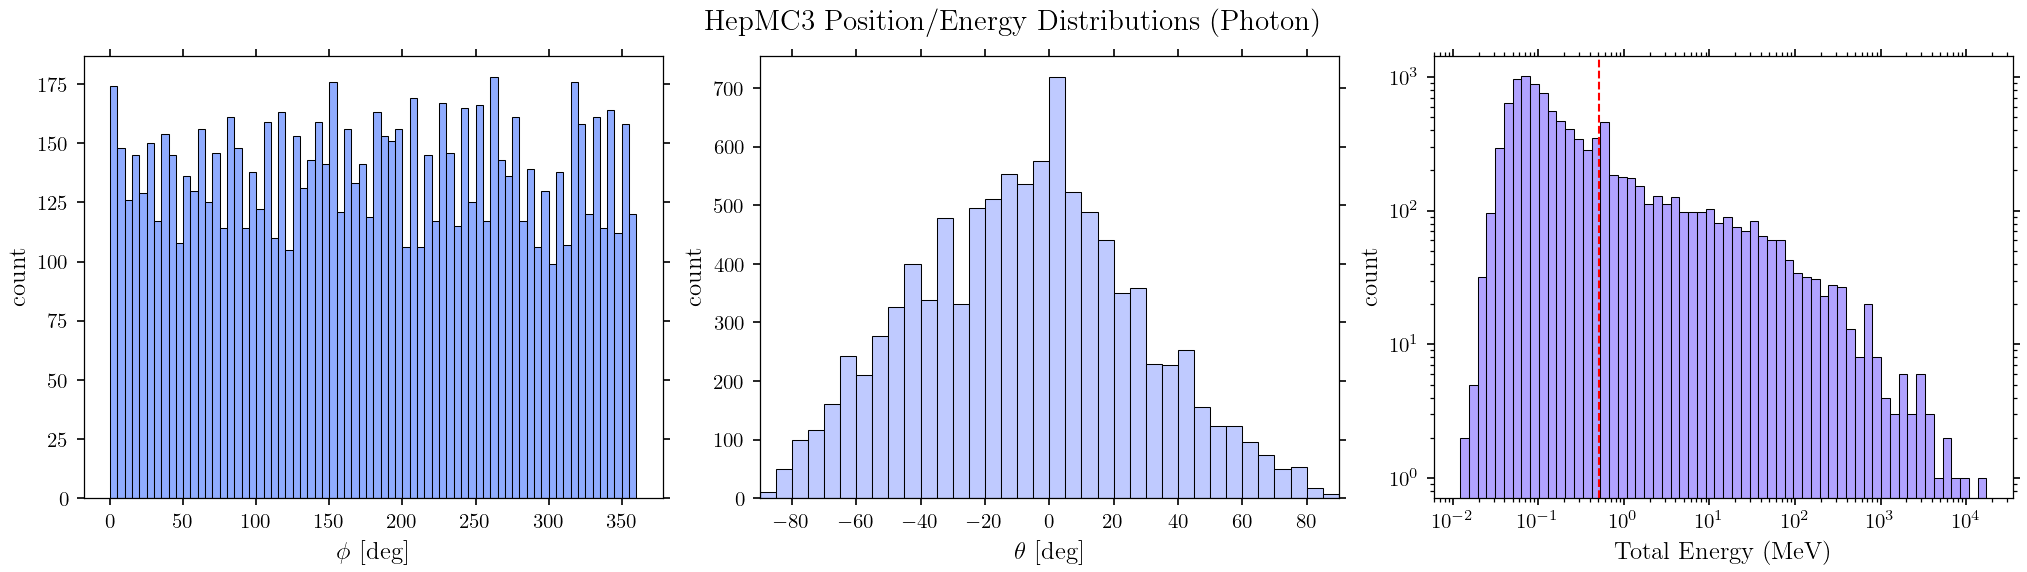

In [21]:
# convert angles to degrees
ph_deg = np.degrees(np.mod(ph_list, 2*np.pi))
th_deg = np.degrees(th_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# phi
axes[0].hist(ph_deg, bins=72, range=(0.0, 360.0), color="#90ACFF", edgecolor='black', lw=0.5)
axes[0].set_xlabel("$\\phi$ [deg]")
axes[0].set_ylabel("count")

# Theta (degrees)
axes[1].hist(th_deg, bins=36, range=(-90.0, 90.0), color="#BFCAFF", edgecolor='black', lw=0.5)
axes[1].set_xlabel("$\\theta$ [deg]")
axes[1].set_ylabel("count")
axes[1].set_xlim(-90, 90)

# Energy with log-scaled x-axis and log-spaced bins
E = np.asarray(E_list)
Epos = E[E > 0]
emin = max(np.min(Epos), 1e-12) if Epos.size else 1e-12
emax = np.max(Epos) if Epos.size else 1.0
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

axes[2].hist(Epos, bins=bins, color="#9886FFC1", edgecolor='black', lw=0.5)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Total Energy (MeV)")
axes[2].set_ylabel("count")
if particle=='photon': axes[2].axvline(0.511, color='red', linestyle='--', lw=1)

fig.suptitle(f'HepMC3 Position/Energy Distributions ({particle_name})', fontsize=14)

plt.show()


## Run GramsG4

In [22]:
# generate command line call to run GramsG4
for p in [particle]:
    p_name = particle_dict[p][0]
    PDG = particle_dict[p][1]

    fits_file = f'{maps_dir}/fits/{location}_{date}_{p}.fits'
    output_hepmc3 =f'{maps_dir}/sim/{location}_{p}.hepmc3' 
    output_g4 =f'{maps_dir}/sim/{location}_{p}_g4.root'

    # run gramsg4 in a terminal
    command = f'./gramsg4 {options_file} -i {output_hepmc3} -o {output_g4}'
    print(command)

./gramsg4 /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/occupancy_grams.xml -i /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon.hepmc3 -o /nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/sim/tucson_photon_g4.root


In [23]:
import ROOT
ROOT.gSystem.Load("/nevis/tehanu/data/st3624/software/GRAMS/GramsSim-work/libDictionary.so")

output_g4 =f'{maps_dir}/sim/{location}_{particle}_g4.root'

# open the input file and access the g4 tree 
inputFile = ROOT.TFile(output_g4)
tree = ROOT.gDirectory.Get('gramsg4')

# # add friend trees
# tree.AddFriend("ReadoutSim","../GramsSim-work/gramsreadoutsim.root")
# tree.AddFriend("DetSim","../GramsSim-work/gramsdetsim.root")
# tree.AddFriend("gramsg4","../GramsSim-work/gramsg4.root")

In [24]:
# intialize energies_dict; key: event ID, value: total energy deposition
energies_dict = {}
theta_list = []
phi_list = []

# loop through tree and extract energy of primary particles for every event
for entry in tree:
    event = tree.EventID.Index()
    # print("Event ID: ", event)

    energies_dict[event] = 0
    primaries = []
    for trackID, track in tree.TrackList:
        # print(track.PDGCode())
        if track.Process() == "Primary":
            # print(track.Process())
            trajectory = track.Trajectory()
            primary_energy = trajectory[0].momentum.E()
            px, py, pz = trajectory[0].momentum.px(), trajectory[0].momentum.py(), trajectory[0].momentum.pz()
            theta, phi = theta_phi(px, py, pz)
            # print(primary_energy)
            energies_dict[event]=primary_energy
            theta_list.append(theta)
            phi_list.append(phi)

    # print total energy for given event
    # print("Energy for event ", tree.EventID.Index(), ": ", energies_dict[event])


energies = list(energies_dict.values())

# with open("energies.txt", "w") as f:
#     for energy in energies:
#         f.write(str(energy) + "\n")


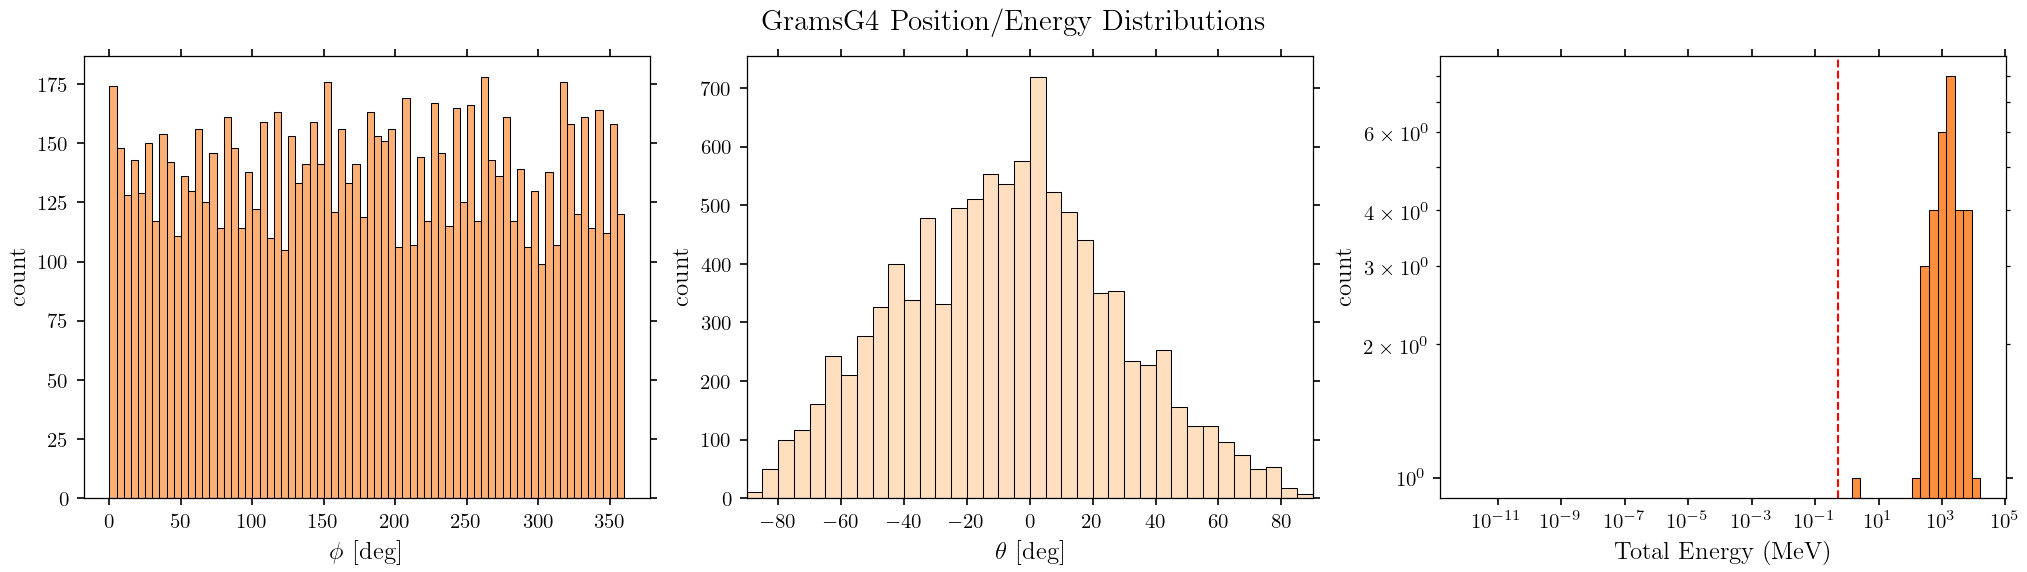

In [25]:
# convert angles to degrees
phi_deg = np.degrees(np.mod(phi_list, 2*np.pi))
theta_deg = np.degrees(theta_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# phi
axes[0].hist(phi_deg, bins=72, range=(0.0, 360.0), color="#FDB076", edgecolor='black', lw=0.5)
axes[0].set_xlabel("$\\phi$ [deg]")
axes[0].set_ylabel("count")

# Theta (degrees)
axes[1].hist(theta_deg, bins=36, range=(-90.0, 90.0), color="#FFDFBF", edgecolor='black', lw=0.5)
axes[1].set_xlabel("$\\theta$ [deg]")
axes[1].set_ylabel("count")
axes[1].set_xlim(-90, 90)

# Energy with log-scaled x-axis and log-spaced bins
E = np.asarray(energies)
Epos = E[E > 0]
m_p = 938.272 # MeV
E_kin = (np.array(Epos)-m_p)
emin = max(np.min(E_kin), 1e-12) if Epos.size else 1e-12
# emin = 0.1
emax = np.max(E_kin) if Epos.size else 1.0
# emax = 100
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

axes[2].hist(E_kin, bins=bins, color="#FF6A00C1", edgecolor='black', lw=0.5)
axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Total Energy (MeV)")
axes[2].set_ylabel("count")
if particle=='photon': axes[2].axvline(0.511, color='red', linestyle='--', lw=1)

fig.suptitle('GramsG4 Position/Energy Distributions', fontsize=14)

plt.show()


In [26]:
print(np.asarray(phi_list)-np.asarray(ph_list))
print(np.asarray(theta_list)-np.asarray(th_list))
print(np.asarray(energies)-np.asarray(E_list))

[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00 -2.22044605e-16 -2.22044605e-16 ...  1.11022302e-16
  0.00000000e+00  0.00000000e+00]
[0.00000000e+00 2.77555756e-17 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


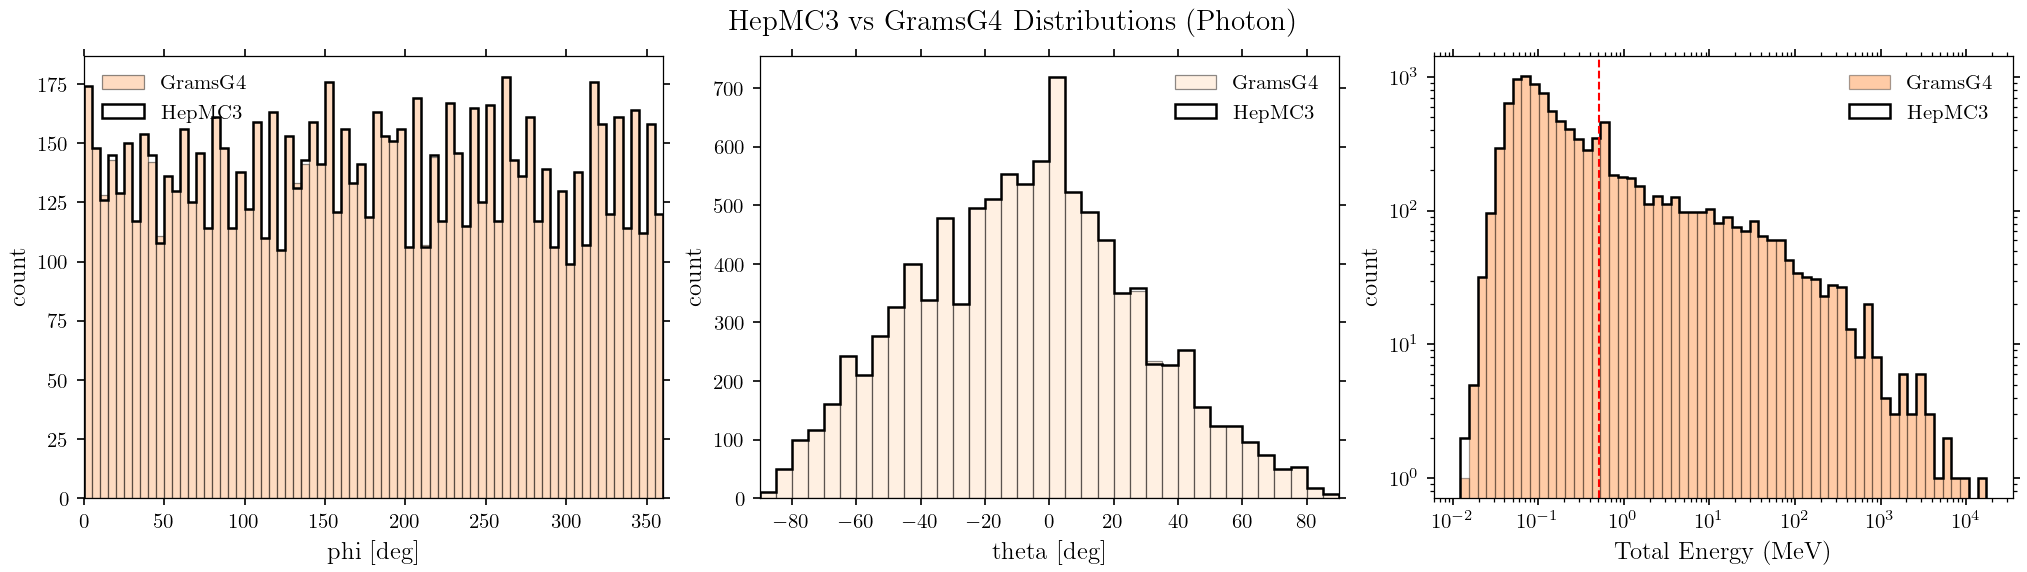

In [27]:
# this block is AI-generated
from matplotlib.ticker import ScalarFormatter

# convert angles to degrees
phi_deg   = np.degrees(np.mod(phi_list, 2*np.pi))
theta_deg = np.degrees(theta_list) - 90

ph_deg = np.degrees(np.mod(ph_list, 2*np.pi))
th_deg = np.degrees(th_list) - 90

fig, axes = plt.subplots(1, 3, figsize=(13.5, 3.8), constrained_layout=True)

# --- phi overlay ---
bins_phi = np.linspace(0.0, 360.0, 73)  # 72 bins
axes[0].hist(phi_deg, bins=bins_phi,
             alpha=0.45, color="#FDB076", edgecolor="black", lw=0.6, label="GramsG4")
axes[0].hist(ph_deg,  bins=bins_phi, histtype="step",
             color="black", lw=1.2, label="HepMC3")
axes[0].set_xlabel("phi [deg]")
axes[0].set_ylabel("count")
axes[0].set_xlim(0, 360)
axes[0].legend(frameon=False)

# --- theta overlay ---
bins_theta = np.linspace(-90.0, 90.0, 37)  # 36 bins
axes[1].hist(theta_deg, bins=bins_theta,
             alpha=0.45, color="#FFDFBF", edgecolor="black", lw=0.6, label="GramsG4")
axes[1].hist(th_deg,    bins=bins_theta, histtype="step",
             color="black", lw=1.2, label="HepMC3")
axes[1].set_xlabel("theta [deg]")
axes[1].set_ylabel("count")
axes[1].set_xlim(-90, 90)
axes[1].legend(frameon=False)

# --- energy overlay ---
E_g4    = np.asarray(energies)
E_g4    = E_g4[E_g4 > 0]
E_hepmc = np.asarray(E_list)
E_hepmc = E_hepmc[E_hepmc > 0]

if E_g4.size and E_hepmc.size:
    emin = min(E_g4.min(), E_hepmc.min())
    emax = max(E_g4.max(), E_hepmc.max())
else:
    emin, emax = (1e-12, 1.0)

bins_E = np.logspace(np.log10(max(emin, 1e-12)), np.log10(emax), 61)

axes[2].hist(E_g4,   bins=bins_E,
             alpha=0.35, color="#FF6A00C1", edgecolor="black", lw=0.6, label="GramsG4")
axes[2].hist(E_hepmc, bins=bins_E, histtype="step",
             color="black", lw=1.2, label="HepMC3")

axes[2].set_xscale("log")
axes[2].set_yscale("log")
axes[2].set_xlabel("Total Energy (MeV)")
axes[2].set_ylabel("count")
if particle=='photon': axes[2].axvline(0.511, color='red', linestyle='--', lw=1)
axes[2].legend(frameon=False)

fig.suptitle(f"HepMC3 vs GramsG4 Distributions ({particle_name})", fontsize=14)
plt.show()


## Simple Rate Stuff to Start

In [28]:
def read_integrated_flux_maps(path: str):
    """
    Read a single-file export of integrated flux maps written by WriteIntegratedFluxMaps.
    
    Returns:
      pixel_idx: (Npix,) int array of pixel indices
      J_bands:   list of length nBands, each element is (Npix,) float array of J_{p,i}
      S:         float, sum over all pixels and bands (cm^-2 s^-1 sr^-1)
    """
    data = np.loadtxt(path, comments="#")
    if data.ndim == 1:
        data = data[np.newaxis, :]

    pixel_idx = data[:, 0].astype(int)
    J_matrix = data[:, 1:]  # shape: (Npix, nBands)
    J_bands = [J_matrix[:, i].copy() for i in range(J_matrix.shape[1])]
    S = sum(float(np.sum(J)) for J in J_bands)
    return pixel_idx, J_bands, S

if particle == 'photon':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_gamma.txt"
elif particle == 'he---4':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_unknown.txt"
elif particle == 'electr':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_e-.txt"
elif particle == 'muplus':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_mu+.txt"
elif particle == 'mumins':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_mu-.txt"
elif particle == 'positr':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_e+.txt"
elif particle == 'neutro':
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_neutron.txt"
else:
    path = f"/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/tucson_2025_8_31_maps/txt/int_flux_{particle}.txt"

pixel_idx, J_bands, S = read_integrated_flux_maps(path)
print(f"Npix={len(pixel_idx)}, nBands={len(J_bands)}, S={S:.6e} cm^-2 s^-1 sr^-1")


Npix=12288, nBands=79, S=6.904431e+03 cm^-2 s^-1 sr^-1


In [ ]:
# weight factor
R_sph = 300 # generation sphere radius; in cm
omega = (4*np.pi)/(12*nside**2) # healpix pixel size in sr
# print('Omega_p:', omega, 'sr')
area = np.pi * (R_sph**2)
# print('Generation sphere cross section:', area, 'cm^2')
# w = S*area*omega

w = S*omega # total number of counts integrated over 1 second, 1 unit area

print('w:', w, 'cm^-2 s^-1')

T = 10000/w

weights = np.full_like(energies, fill_value=1/T, dtype=float)

# weights = np.array(weights)/(area*np.array(energies))

w: 7.06084344994344 cm^-2 s^-1


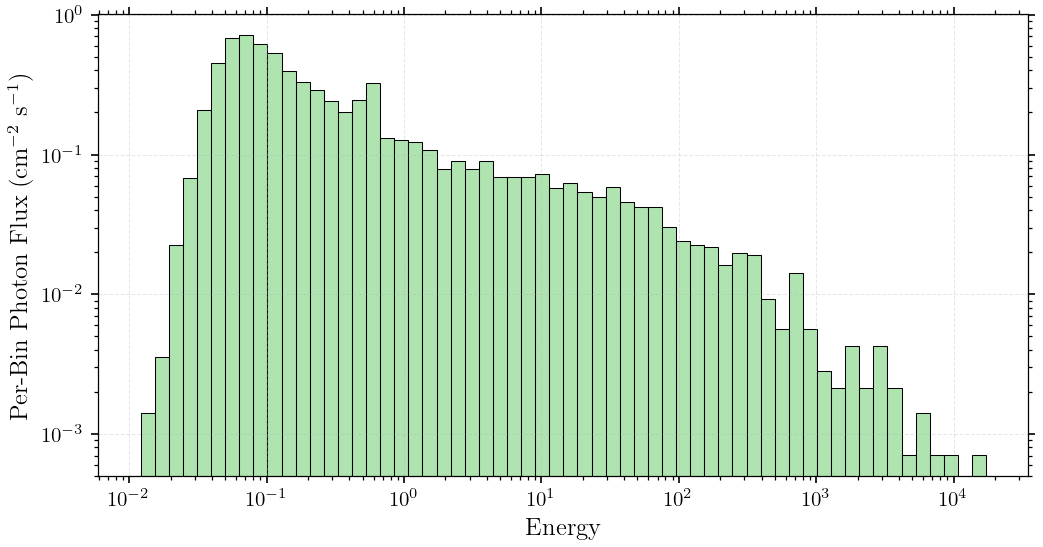

In [30]:
m_he = 3727.38 # MeV
m_p = 938.27 # MeV

particle_mass = m_p

# emin = (0.1*1000)+particle_mass
# emax = (100*1000)+particle_mass


plt.figure(figsize=[8,4])

bins = plt.hist(np.asarray(E_hepmc), weights=weights, bins=bins_E, color="#67CD6A85", edgecolor='black', lw=0.5)
plt.loglog()
plt.xlabel("Energy")
plt.ylabel(fr"Per-Bin {particle_name} Flux (cm$^{{-2}}$ s$^{{-1}}$)")
plt.grid(True, lw=0.5, alpha=0.3)
# plt.axvline(emin, lw=0.8, ls='--', color='r')
# plt.axvline(emax, lw=0.8, ls='--', color='r', label='Range Used for BESS Estimate')
# plt.xlim(0.05, 200)
# plt.legend(frameon=False)
plt.show()

In [1]:
# average area of pGRAMS TPC
area = (2*(30*30)+4*(30*20))/6
print('Total surface area of pGRAMS TPC:', 6*area, 'cm^2')
print('Average Cross-section of pGRAMS TPC:', area, 'cm^2')

Total surface area of pGRAMS TPC: 4200.0 cm^2
Average Cross-section of pGRAMS TPC: 700.0 cm^2


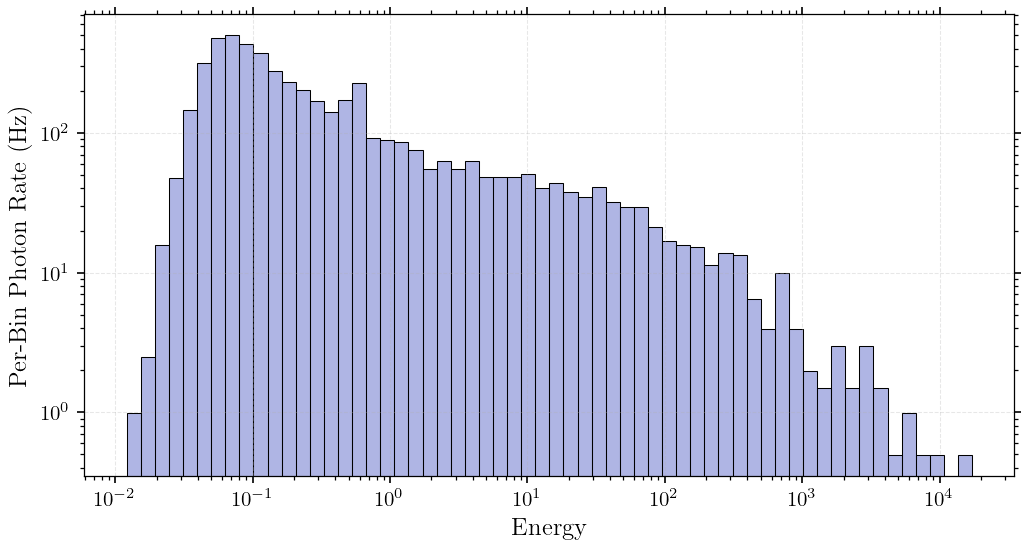

In [32]:
# m_he = 3727.38 # MeV
# m_p = 938.27 # MeV

# particle_mass = m_p

# emin = (0.1*1000)+particle_mass
# emax = (100*1000)+particle_mass


plt.figure(figsize=[8,4])

bins = plt.hist(np.asarray(E_hepmc), weights=np.asarray(weights)*area, bins=bins_E, color="#6771CD85", edgecolor='black', lw=0.5)
plt.loglog()
plt.xlabel("Energy")
plt.ylabel(fr"Per-Bin {particle_name} Rate (Hz)")
plt.grid(True, lw=0.5, alpha=0.3)
# plt.axvline(emin, lw=0.8, ls='--', color='r')
# plt.axvline(emax, lw=0.8, ls='--', color='r', label='Range Used for BESS Estimate')
# plt.xlim(0.05, 200)
# plt.legend(frameon=False)
plt.show()

In [33]:
# integrate rate using hepmc3 distribution

m_he = 3727.38 # MeV
m_p = 938.27 # MeV

particle_mass = m_he

# emin = (0.1*1000)+particle_mass
# emax = (100*1000)+particle_mass

emin = np.min(E_hepmc[E_hepmc > 0])
emax = np.max(E_hepmc)
# emin = 0.05
# emax = 200
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

counts, bins = np.histogram(E_hepmc, bins, weights=np.asarray(weights)*area)

# E_edges = bins[1]
# counts = bins[0]

rate_per_bin = counts
total_rate = rate_per_bin.sum()
print(f"Total {particle} rate from {emin:.3e} to {emax:.3e} MeV = {total_rate:.3e} Hz")

# Compare to analytic expectation from maps:
# R_expected = area * omega * S  # S_use is S (or scaled S)
# print(f"Expected primary rate from maps = {R_expected:.3e} Hz")

# # Optional: convert to rate density per MeV for fair visual comparison across E
# widths = np.diff(E_edges)
# # rate_density = rate_per_bin / widths

Total photon rate from 1.211e-02 to 1.725e+04 MeV = 4.943e+03 Hz


### Rate of Detector Interactions

In [34]:
prim_energy_for_hit_events = []      # list of primary energies, one per event with ≥1 LArHit
event_to_primary_energy = {}

for entry in tree:
    event = tree.EventID.Index()

    # check if event has any MCLArHits
    has_hit = False
    for key, hit in tree.LArHits:
        has_hit = True
        break

    if not has_hit:
        continue  # skip events without any MCLArHits

    # primary track in this event and take its initial energy
    primary_energy = None
    for trackID, track in tree.TrackList:
        if track.Process() == "Primary":
            traj = track.Trajectory()
            if len(traj) > 0:
                primary_energy = traj[0].momentum.E()
                break  # if only one primary is expected

    if primary_energy is not None:
        prim_energy_for_hit_events.append(primary_energy)
        event_to_primary_energy[event] = primary_energy

In [35]:
len(prim_energy_for_hit_events)

2523

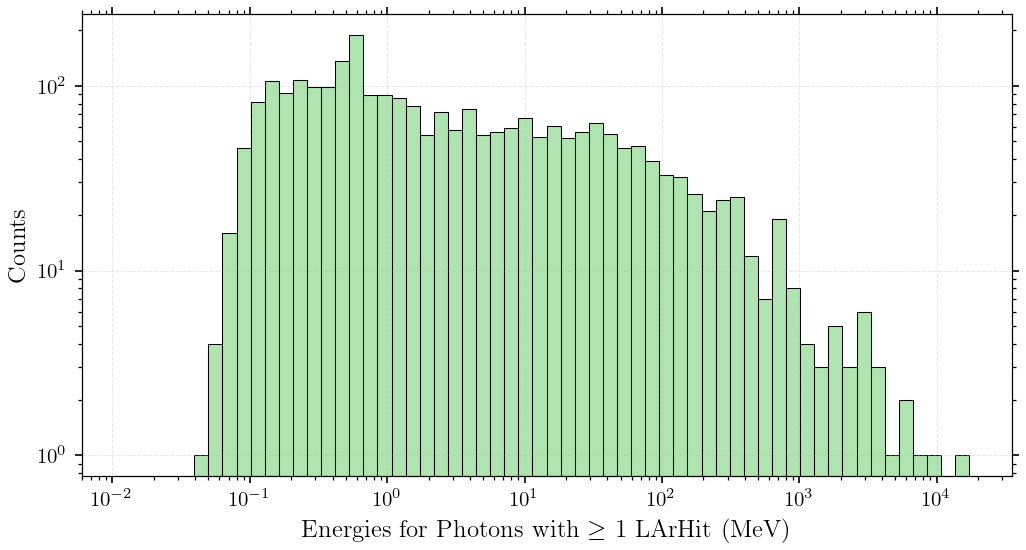

In [36]:
plt.figure(figsize=[8,4])

bins = plt.hist(np.asarray(prim_energy_for_hit_events), bins=bins_E, color="#67CD6A85", edgecolor='black', lw=0.5)
plt.loglog()
plt.xlabel(f"Energies for {particle_name}s with $\\geq$ 1 LArHit (MeV)")
plt.ylabel(f"Counts")
plt.grid(True, lw=0.5, alpha=0.3)
# plt.axvline(emin, lw=0.8, ls='--', color='r')
# plt.axvline(emax, lw=0.8, ls='--', color='r', label='Range Used for BESS Estimate')
# plt.xlim(0.05, 200)
# plt.legend(frameon=False)
plt.show()

Total photon rate from 4.847e-02 to 1.725e+04 MeV = 1.247e+03 Hz


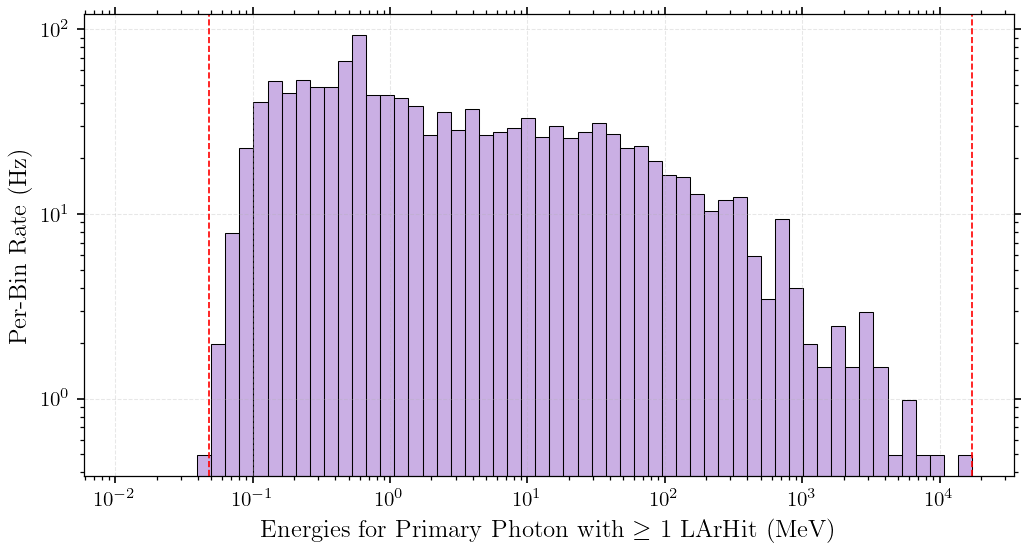

In [37]:
weights = np.full_like(prim_energy_for_hit_events, fill_value=1/T, dtype=float)

plt.figure(figsize=[8,4])

bins = plt.hist(np.asarray(prim_energy_for_hit_events), weights=np.asarray(weights)*area, bins=bins_E, color="#9A67CD85", edgecolor='black', lw=0.5)
plt.loglog()
plt.xlabel(f"Energies for Primary {particle_name} with $\\geq$ 1 LArHit (MeV)")
plt.ylabel(fr"Per-Bin Rate (Hz)")
plt.grid(True, lw=0.5, alpha=0.3)

emin = np.min(np.asarray(prim_energy_for_hit_events)[np.asarray(prim_energy_for_hit_events) > 0])
emax = np.max(np.asarray(prim_energy_for_hit_events))
# emin = 0.05
# emax = 200
bins = np.logspace(np.log10(emin), np.log10(emax), 61)

counts, bins = np.histogram(np.asarray(prim_energy_for_hit_events), bins, weights=np.asarray(weights)*area)

# E_edges = bins[1]
# counts = bins[0]

rate_per_bin = counts
total_rate = rate_per_bin.sum()
print(f"Total {particle} rate from {emin:.3e} to {emax:.3e} MeV = {total_rate:.3e} Hz")

plt.axvline(emin, lw=0.8, ls='--', color='r')
plt.axvline(emax, lw=0.8, ls='--', color='r', label='Range Used for BESS Estimate')
# plt.xlim(0.05, 200)
# plt.legend(frameon=False)
plt.show()

### Ionization Rate

In [40]:
from tqdm import tqdm
ionizationQ = {}

# loop through tree and extract energy of primary particles for every event
for entry in tqdm(tree):
    event = tree.EventID.Index()
    # primaryE[event] = 0
    primaries = []
    for trackID, track in tree.TrackList:
        if track.Process() == "Primary":
            trajectory = track.Trajectory()
            primary_energy = trajectory[0].momentum.E()
            # primaryE[event] = primary_energy

    Q_sum = 0
    for hitID, hit in tree.LArHits:
        # if primary_energy < 0.5  or primary_energy > 200:
            # continue
        trackID = hit.TrackID()
        num_e = (1/23.6) * hit.Energy() * 1e6
        Q = num_e * 1.6e-19
        Q_sum += Q
    ionizationQ[event] = Q_sum

ionization_charges = list(ionizationQ.values())

10000it [05:36, 29.70it/s]


In [63]:
len(ionization_charges)

10000

In [35]:
flat_gps_charge = np.loadtxt("/nevis/tehanu/data/st3624/software/GRAMS/GramsOccupancy/AreaValidation/FlatGPS/ionizationQ.txt")

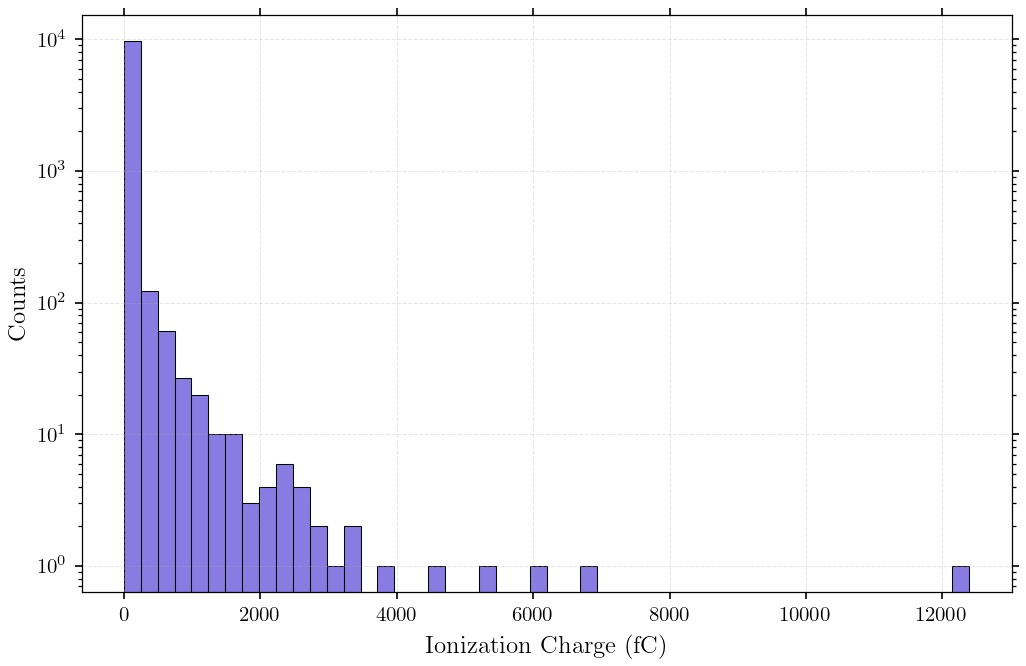

In [36]:
# match binning and compare flat_gps_charge and ionization_charges
plt.hist(np.asarray(ionization_charges)*10**15, bins=50, color="#897BE2", edgecolor='black', lw=0.5)
plt.semilogy()
plt.xlabel("Ionization Charge (fC)")
plt.ylabel("Counts")
plt.grid(True, lw=0.5, alpha=0.3)
plt.show()

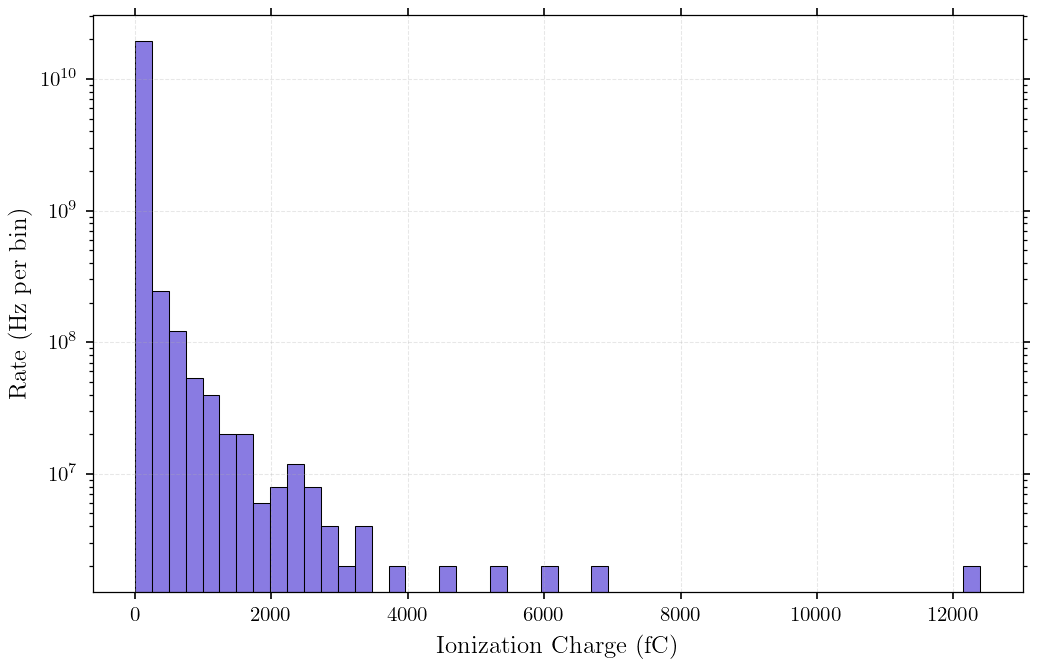

Total rate in histogram = 1.996406e+10 Hz


In [37]:
# Assume you already computed:
#   w  -> constant per-event weight in s^-1 (Hz)
#   ionization_charges -> iterable of charges in Coulombs per event (unweighted)
# This cell plots a rate-weighted histogram (Hz per bin) with x-axis in fC.

import numpy as np
import matplotlib.pyplot as plt

# Convert charges to femtocoulombs for x-axis
charges_fC = np.asarray(ionization_charges, dtype=float) * 1e15  # C -> fC

# Choose bins (same as your original: 50 bins spanning the data range)
bins = 50

# Each event contributes weight 'w' Hz. So the histogram will be in Hz per bin.
weights = np.full_like(charges_fC, fill_value=w, dtype=float)

# Make the weighted histogram (rates)
counts_per_bin, bin_edges, _ = plt.hist(
    charges_fC,
    bins=bins,
    weights=weights,
    color="#897BE2",
    edgecolor="black",
    lw=0.5
)

# Log-y as before
plt.semilogy()

# Labels with correct units
plt.xlabel("Ionization Charge (fC)")
plt.ylabel("Rate (Hz per bin)")
plt.grid(True, lw=0.5, alpha=0.3)
plt.show()

# Optional: print total integrated rate under the histogram (should equal N_events * w)
total_rate = counts_per_bin.sum()
print(f"Total rate in histogram = {total_rate:.6e} Hz")
